In [1]:
import os
os.chdir('..')

import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from nn_homology import nn_graph

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

In [14]:
# Global-like variable definitions.
model_name = 'lenet5'
dataset_name = 'cifar10'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
seed = 0 # prune percentage for LT network
model_loc0 = 'remote_saves/{}/{}/{}/prune_all/0/model_lt_20.pth.tar'.format(model_name, dataset_name, seed) # location of saved, un-pruned model 
model_loc1 = 'remote_saves/{}/{}/{}/prune_all/9/model_lt_20.pth.tar'.format(model_name, dataset_name, seed) # location of saved, pruned model (after 1 prune iteration)
input_size = (1,3,32,32)
from archs.cifar10.LeNet5 import LeNet5 as Mc

## Unpruned Model Homology

In [15]:
# load the model.
model = torch.load(model_loc0)
model_class = Mc()

In [16]:
NNG = nn_graph.NNGraph()
NNG.parameter_graph(model, model_class.param_info, input_size, ignore_zeros=True, verbose=True)

Layer: Conv1
Layer: MaxPool1
Layer: Conv2
Layer: MaxPool2
Layer: Linear1
Layer: Linear2
Layer: Linear3


In [17]:
# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

def sparse_min_row(csr_mat):
    ret = np.zeros(csr_mat.shape[0])
    ret[np.diff(csr_mat.indptr) != 0] = np.minimum.reduceat(csr_mat.data,csr_mat.indptr[:-1][np.diff(csr_mat.indptr)>0])
    return ret

In [18]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.CIFAR10(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 56.79


In [19]:
# compute rips homology 
sps = nx.to_scipy_sparse_matrix(NNG.G)
mrs = sparse_min_row(sps)
sps.setdiag(mrs)

%time rips = ripser(sps, distance_matrix=True, maxdim=1)
rips

/home/schraterlab/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 161 ms, sys: 4.06 ms, total: 165 ms
Wall time: 165 ms


{'dgms': [array([[0.61736077, 0.63748354],
         [0.61736077, 0.63748354],
         [0.61736077, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.61736077, 0.63748354],
         [0.61736077, 0.63748354],
         [0.61736077, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.61736077, 0.63748354],
         [0.61736077, 0.63748354],
         [0.61736077, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.62371856, 0.63748354],
         [0.61736077, 0.63748354],
         [0.61736077, 0.63748354],
         [0.61736077, 0.63748354],
         [0.62371856, 0.63748354],
         [0.

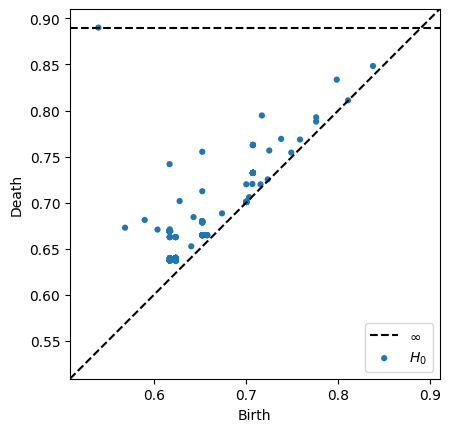

In [20]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'][0])

## Pruned LT Homology

In [21]:
# load the LT model.
model_lt = torch.load(model_loc1)

In [22]:
# test this model's accuracy.
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 32.87


In [23]:
NNGLT = nn_graph.NNGraph()
NNGLT.parameter_graph(model_lt, model_class.param_info, input_size, ignore_zeros=True, verbose=True)

Layer: Conv1
Layer: MaxPool1
Layer: Conv2
Layer: MaxPool2
Layer: Linear1
Layer: Linear2
Layer: Linear3


In [24]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
sps = nx.to_scipy_sparse_matrix(NNGLT.G)
mrs = sparse_min_row(sps)
sps.setdiag(mrs)
%time rips_lt = ripser(sps, distance_matrix=True, maxdim=1)
rips_lt

CPU times: user 12.6 ms, sys: 25 µs, total: 12.7 ms
Wall time: 12.7 ms


/home/schraterlab/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


{'dgms': [array([[0.41633585, 0.45550677],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.47571957, 0.49502617],
         [0.

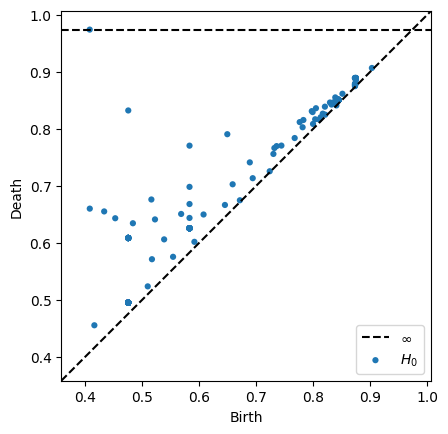

In [26]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'][0])